In [2]:
#!pip install matplotlib


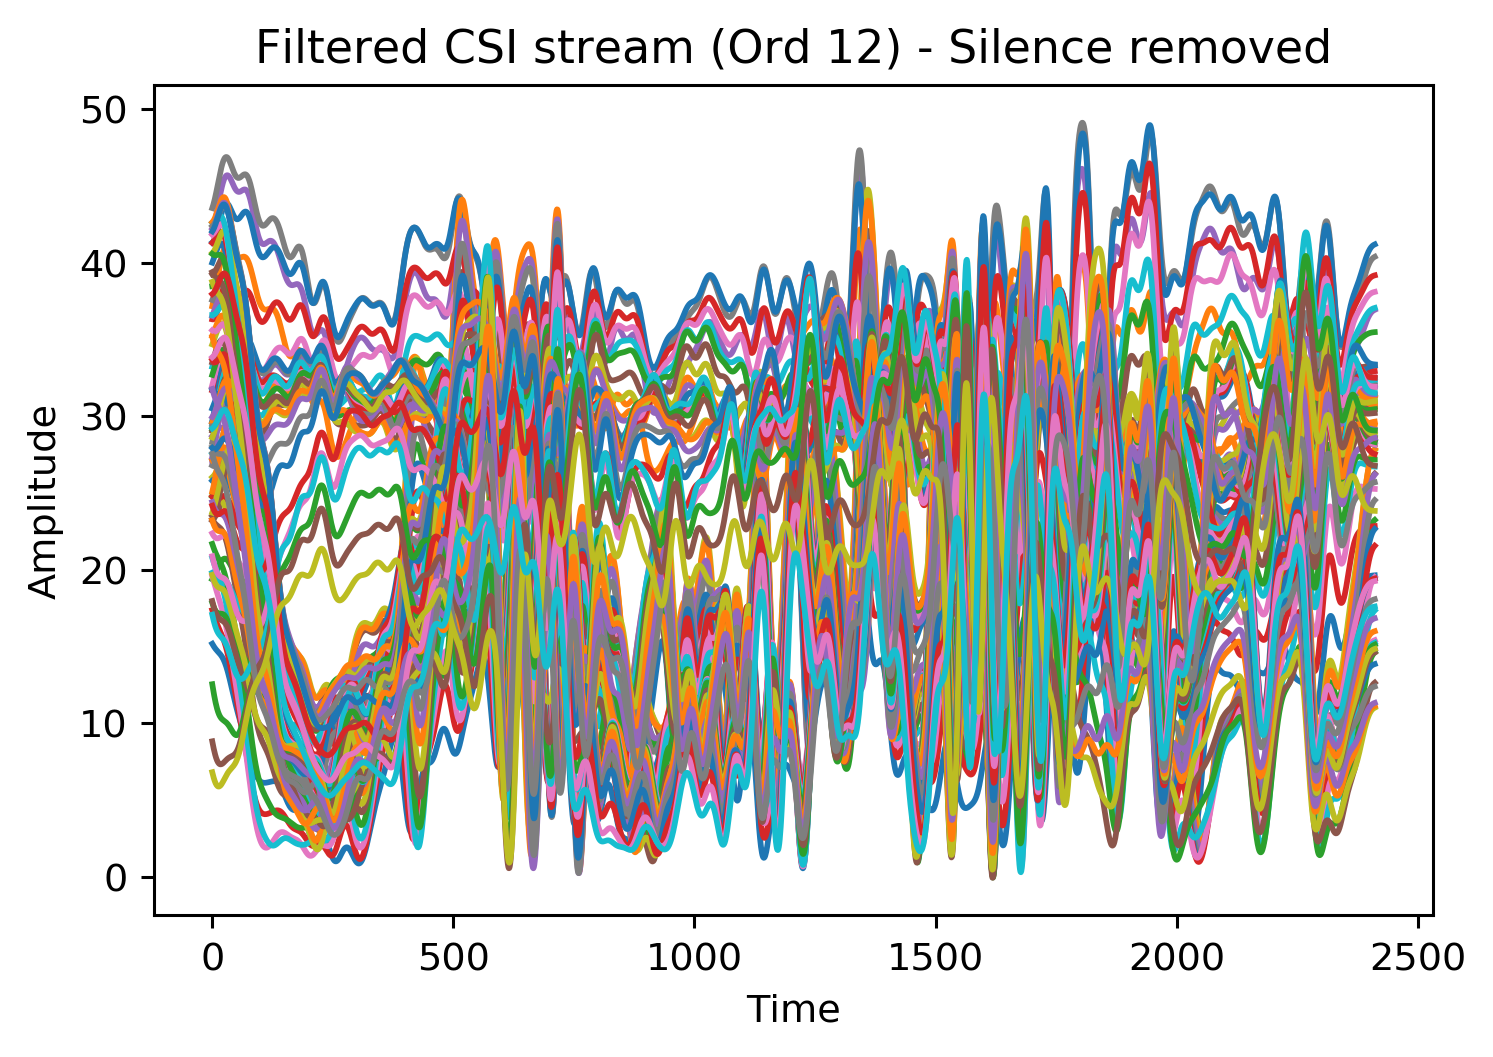

In [496]:

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, medfilt
from numpy.fft import fft, fftfreq, ifft

matlab_file = './NEW/sushant/converted/log_1.mat'
# matlab_file = './NEW/soham/converted/log_1.mat'
# matlab_file = './NEW/vin/converted/log_1.mat'
# matlab_file = './Environment_CSI/converted/log1.mat'
plt.rcParams['figure.dpi'] = 275

original = [] # Dataset with trimmed csi streams, removed silence
selected_subcarrier = 0

mat_contents = sio.loadmat(matlab_file)
antenna = mat_contents['M']

# -- APPLY BUTTERWORTH FILTER --
for subcarrier in range(90):
    fs = 0.05        # Sampling Frequency
    flt_ord = 12     # Filter order number

    # Create list of CSI stream of one subcarrier
    x_axis = []
    y_axis = []
    for i in range(0, len(antenna)):
        x_axis.append(i)
        y_axis.append(antenna[i][subcarrier])

    flt_ord = 12
    b, a = butter(flt_ord, 0.05, 'lowpass', analog=False)
    output = filtfilt(b, a, y_axis)
    original.append(output)


# -- SILENCE REMOVAL ---
# Separate the CSI data into a sequence of frames
num_packets = len(original[selected_subcarrier])
data_per_frame = 50    # 50 ms is the number of data(frequency) in each frame.
total_num_frames = math.floor(num_packets/data_per_frame) 
frames = []
for frame in range(int(total_num_frames)):
    cur_index = data_per_frame*frame
    seq = original[selected_subcarrier][cur_index : cur_index+data_per_frame]
    frames.append(seq)


# Calculate energy for each frame
# Energy each frame = Average of the Squares for each frame
energy = []
for frame in frames:
    sq_sum = sum(map(lambda x: x*x, frame))
    e_frame = sq_sum/data_per_frame
    energy.append(e_frame)

# Apply median filter to energy values and take their log
filt_energy = medfilt(energy)
filt_energy = [math.log(e) for e in filt_energy]

# Select contiguous block of frames s_mid for which energy > mean energy

# Get indices for which energy > mean energy
curr_index = 0
high_energy_indices = []
mean_energy = sum(filt_energy)/len(filt_energy)
for energy in filt_energy:
    if energy > mean_energy:
        high_energy_indices.append(curr_index)
    curr_index += 1;

# Split the high energy indices into contigious subsequences
curr_index = None
inside_arr = []
conti_arr = []
for index in high_energy_indices:
    if (curr_index is None):
        inside_arr.append(index)
    else:
        if (curr_index == index-1):
            inside_arr.append(index)
        else:
            conti_arr.append(inside_arr)
            inside_arr = []
            inside_arr.append(index)

    curr_index = index

if inside_arr:
    conti_arr.append(inside_arr)

# Select the longest contigious subsequence
s_mid = max(conti_arr, key=len)

# Get the corresponding CSI data frames h_mid for s_mid
h_mid = []
for index in s_mid:
    h_mid.append(frames[index])

    
# Calculate the midpoint of the region h_mid which has maximum
# deviations from the average in h_mid
high_energy_csi = [item for sublist in h_mid for item in sublist]
avg_energy = sum(high_energy_csi)/len(high_energy_csi)

max_dev = 0
max_dev_index = 0
for index, energy in enumerate(high_energy_csi):
    deviation = abs(avg_energy - energy)
    if deviation > max_dev:
        max_dev = deviation
        max_dev_index = index

m = s_mid[0] * data_per_frame + max_dev_index 

# Set start_point to m−T/2, where T is total duration
start_point = math.floor(m - (num_packets)/2)
start_point = max(start_point, 0)

# Set end_point to m+T/2, where T is total duration
end_point = math.floor(m + (num_packets)/2)
end_point = min(end_point, num_packets)

# Get original data with silence removed
trimmed_output = original[selected_subcarrier][start_point:end_point]

silenced_data = [] # Contains the original csi data for which each subcarrier is trimmed from best_start to best_end
for untrimmed in original:
    new_csi = untrimmed[start_point:end_point]
    silenced_data.append(new_csi)


# # Plot the silenced CSI data
for silenced in silenced_data:
    plt.plot(silenced)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Filtered CSI stream (Ord 12) - Silence removed')

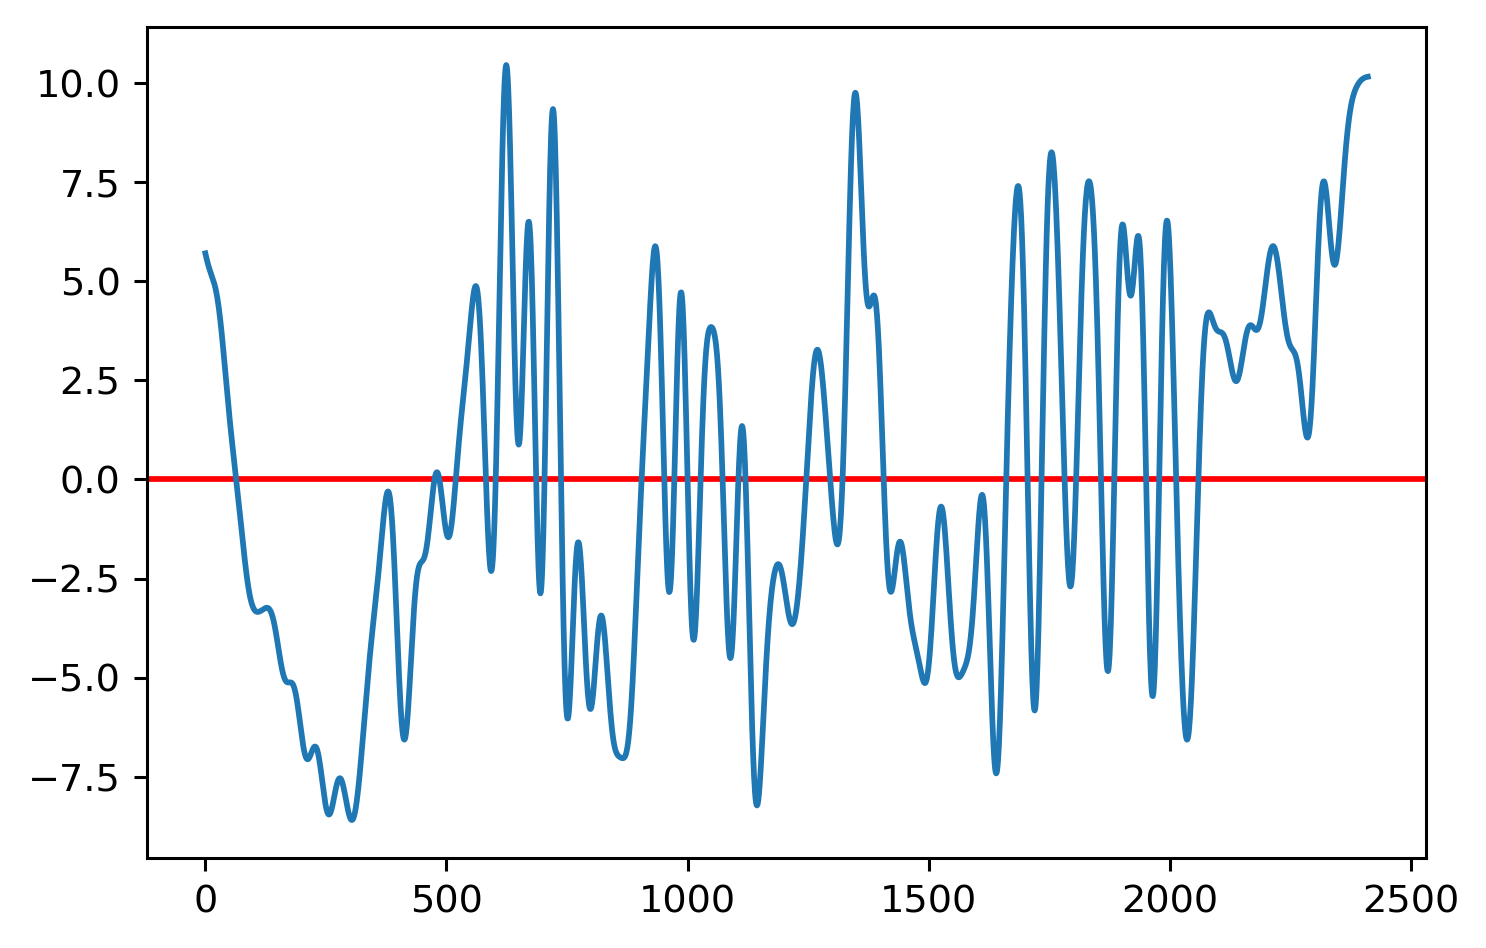

In [497]:
# Shift data by mean
silenced_csi_signal = silenced_data[selected_subcarrier]
mean_silenced = sum(silenced_csi_signal)/len(silenced_csi_signal)
shifted_data = [i - mean_silenced for i in silenced_csi_signal]

plt.axhline(y=0, color='r', linestyle='-')
plt.plot(shifted_data)


[ 3.94706490e-11   +0.j          3.16974274e+03-8606.9592913j
 -1.53476812e+03 +574.82738593j ... -1.08194104e+03-2507.89386778j
 -1.53476812e+03 -574.82738593j  3.16974274e+03+8606.9592913j ]
4440
8881


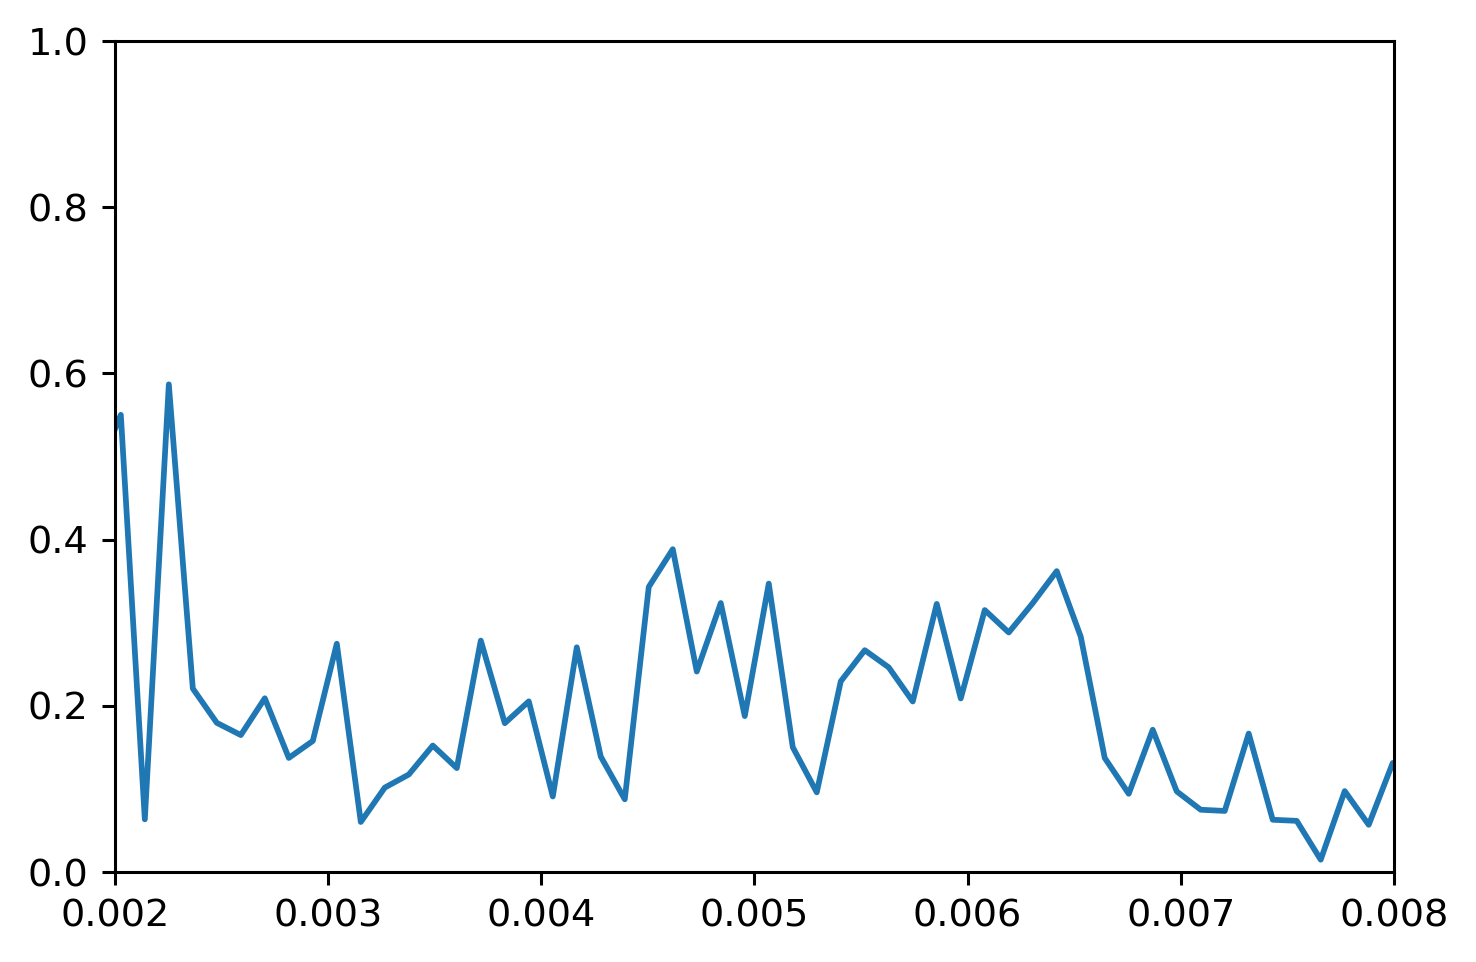

In [273]:
# Perform FFT
n = len(shifted_data)
timestep = 1
freq = fftfreq(n, d=timestep)
mask = freq > 0
xmin = 0.002; xmax = 0.008
ymin = 0; ymax = 1

frequency_data = fft(shifted_data)
print(frequency_data)
fft_theo = 2.0*np.abs(frequency_data/n)
plt.axis([xmin,xmax,ymin,ymax])
plt.plot(freq[mask], fft_theo[mask])

# plt.plot(frequency_data, fft_theo)



print(len(freq[mask]))
print(n)

# plt.ylim(bottom=0.002, top=0.008)
# plt.plot([i for i in range(n)], freq)

# print(fft_theo[mask])
# print(freq)
separated_freq = [f for f in freq if (f > 0.002 and f < 0.008)]
actual_val = ifft(separated_freq)

# import scipy
# f = 1000 * np.arange(0, n // 2 + 1) / n; # resampled frequency vector
# Y = scipy.fftpack.fft(shifted_data)
# P2 = np.abs(Y / n)
# P1 = P2[0 : n // 2 + 1]
# P1[1 : -2] = 2 * P1[1 : -2]

# plt.ylabel("Y")
# plt.xlabel("f")
# plt.plot(f, P1)

In [472]:
# from scipy.stats import kurtosis, skew
#from skrebate import ReliefF
#from sklearn.pipeline import make_pipeline
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score


# Feature extraction shit here.
# num_packets = len(silenced_data[selected_subcarrier])
# data_per_window = 100
# total_num_windows = math.floor(num_packets/data_per_window) 

# # Split data into windows of 100 packets / 0.1 seconds
# windows = []
# for window in range(int(total_num_windows)):
#     cur_index = data_per_window*window
#     seq = silenced_data[selected_subcarrier][cur_index : cur_index+data_per_window]
    
#     windows.append(seq)

# #print(windows)

# features = []

# def getZeroCrossingRate(arr):
#         my_array = np.array(arr)
#         #print(my_array)
#         return float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr)))
    
# def getMeanCrossingRate(arr):
#     #print(arr)
#     return getZeroCrossingRate(np.array(arr) - np.mean(arr))

# For each window, gather its features
# for each_window in windows:
#     # time domain features
    
#     weight_each_window = []
    
#     mean = sum(each_window) / len(each_window)
#     max_val = max(each_window)
#     min_val = min(each_window)
#     skewness = skew(each_window)
#     kurtosis_val = kurtosis(each_window)
#     variance = np.var(each_window)
    
#     # !!! MEAN crossing rate shit doesnt work !!!
# #     mean_crossing_rate = getMeanCrossingRate(each_window)
    
#     weight_each_window.append(mean)
#     weight_each_window.append(max_val)
#     weight_each_window.append(min_val)
#     weight_each_window.append(skewness)
#     weight_each_window.append(kurtosis_val)
#     weight_each_window.append(variance)
# #     weight_each_window.append(mean_crossing_rate)
    
#     features.append(weight_each_window)

# print(mean)
# print(max_val)
# print(min_val)
# print(skewness)
# print(kurtosis_val)
# print(variance)
# print(mean_crossing_rate)

# print(features)
# label_len = len(features)
# labels = np.zeros(label_len)

# print(labels)
# clf = make_pipeline(ReliefF(n_features_to_select=2, n_neighbors=100),
#                     RandomForestClassifier(n_estimators=100))


# print(clf)
# print(np.mean(cross_val_score(clf, features, labels)))



In [488]:
# Feature extraction - all subcarriers
from scipy.stats import kurtosis, skew

features = []

for subcarrier in range(len(silenced_data)):
    num_packets = len(silenced_data[subcarrier])
    data_per_window = 100
    total_num_windows = math.floor(num_packets/data_per_window) 

    # Split data into windows of 100 packets / 0.1 seconds
    windows = []
    for window in range(int(total_num_windows)):
        cur_index = data_per_window*window
        seq = silenced_data[subcarrier][cur_index : cur_index+data_per_window]

        windows.append(seq)

    # For each window, gather its features
    for each_window in windows:
        # time domain features

        weight_each_window = []

        mean = sum(each_window) / len(each_window)
        max_val = max(each_window)
        min_val = min(each_window)
        skewness = skew(each_window)
        kurtosis_val = kurtosis(each_window)
        variance = np.var(each_window)

        weight_each_window.append(mean)
        weight_each_window.append(max_val)
        weight_each_window.append(min_val)
        weight_each_window.append(skewness)
        weight_each_window.append(kurtosis_val)
        weight_each_window.append(variance)

        features.append(weight_each_window)


In [328]:
# Feature extraction - all subcarriers - shifted data
# from scipy.stats import kurtosis, skew

# features = []

# for subcarrier in range(len(silenced_data)):
#     silenced_csi_signal = silenced_data[subcarrier]
#     mean_silenced = sum(silenced_csi_signal)/len(silenced_csi_signal)
#     shifted_data = [i - mean_silenced for i in silenced_csi_signal]
    
#     num_packets = len(shifted_data)
#     data_per_window = 100
#     total_num_windows = math.floor(num_packets/data_per_window) 

#     # Split data into windows of 100 packets / 0.1 seconds
#     windows = []
#     for window in range(int(total_num_windows)):
#         cur_index = data_per_window*window
#         seq = shifted_data[cur_index : cur_index+data_per_window]

#         windows.append(seq)

#     # For each window, gather its features
#     for each_window in windows:
#         # time domain features

#         weight_each_window = []

#         mean = sum(each_window) / len(each_window)
#         max_val = max(each_window)
#         min_val = min(each_window)
#         skewness = skew(each_window)
#         kurtosis_val = kurtosis(each_window)
#         variance = np.var(each_window)

#         weight_each_window.append(mean)
#         weight_each_window.append(max_val)
#         weight_each_window.append(min_val)
#         weight_each_window.append(skewness)
#         weight_each_window.append(kurtosis_val)
#         weight_each_window.append(variance)

#         features.append(weight_each_window)


In [483]:
# Export Sushant data
sushant_data = {
    'feature_names': [
        'mean',
        'max_val',
        'min_val',
        'skewness',
        'kurtosis_val',
        'variance'
    ],
    'features': features,
    'target_name': 'Sushant',
    'target': 0
}

import json
with open('sushant_data.json', 'w') as outfile:
    json.dump(sushant_data, outfile, indent=4)

In [486]:
# Export Soham data
soham_data = {
    'feature_names': [
        'mean',
        'max_val',
        'min_val',
        'skewness',
        'kurtosis_val',
        'variance'
    ],
    'features': features,
    'target_name': 'Soham',
    'target': 1
}

import json
with open('soham_data.json', 'w') as outfile:
    json.dump(soham_data, outfile, indent=4)

In [489]:
# Export Vintony data
vintony_data = {
    'feature_names': [
        'mean',
        'max_val',
        'min_val',
        'skewness',
        'kurtosis_val',
        'variance'
    ],
    'features': features,
    'target_name': 'Vintony',
    'target': 2
}

import json
with open('vintony_data.json', 'w') as outfile:
    json.dump(vintony_data, outfile, indent=4)

In [402]:
# Export Environment data
environment_data = {
    'feature_names': [
        'mean',
        'max_val',
        'min_val',
        'skewness',
        'kurtosis_val',
        'variance'
    ],
    'features': features,
    'target_name': 'Environment',
    'target': 3
}

import json
with open('environment_data.json', 'w') as outfile:
    json.dump(environment_data, outfile, indent=4)

In [474]:
# Preprocess for building classifier
with open('sushant_data.json') as json_file:
    sushant = json.load(json_file)
    
with open('soham_data.json') as json_file:
    soham = json.load(json_file)
    
with open('vintony_data.json') as json_file:
    vintony = json.load(json_file)
    
with open('environment_data.json') as json_file:
    environment = json.load(json_file)

data_length = len(sushant['features']) + len(environment['features']) + len(soham['features']) + len(vintony['features'])
csi_data ={
    'feature_names': sushant['feature_names'],
    'features': np.array(sushant['features'] + soham['features'] + vintony['features'] + environment['features']),
    'target_names': ['Sushant', 'Soham', 'Vintony', 'Environment'],
    'target': np.empty(data_length)
}
csi_data['target'][0:len(sushant['features'])] = 0
csi_data['target'][len(sushant['features']): len(soham['features'])] = 1
csi_data['target'][len(soham['features']): len(vintony['features'])] = 2
csi_data['target'][len(vintony['features']): data_length] = 3


# print(csi_data)

import pandas as pd
data = pd.DataFrame({
        'mean': csi_data['features'][:,0],
        'max_val': csi_data['features'][:,1],
        'min_val': csi_data['features'][:,2],
        'skewness': csi_data['features'][:,3],
        'kurtosis_val': csi_data['features'][:,4],
        'variance': csi_data['features'][:,5],
        'person': csi_data['target']
})

from sklearn.utils import shuffle
data = shuffle(data)

from sklearn.model_selection import train_test_split

# features
X = data[['mean', 'max_val', 'min_val', 'skewness', 'kurtosis_val', 'variance']]
# labels
y = data['person']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


# HERE IS WHERE I SHOULD GET THE DATAAA.

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# print(y_test)
print(y_pred)
# for i in y_pred:
#     print(csi_data['target_names'][int(i)])
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

feature_imp = pd.Series(clf.feature_importances_,index=csi_data["feature_names"]).sort_values(ascending=False)
feature_imp

[3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.9883303411131059


variance        0.307241
max_val         0.168810
mean            0.157625
min_val         0.127417
kurtosis_val    0.125113
skewness        0.113795
dtype: float64

In [493]:
# Preprocess for building classifier
with open('sushant_data.json') as json_file:
    sushant = json.load(json_file)
    
with open('soham_data.json') as json_file:
    soham = json.load(json_file)
    
with open('vintony_data.json') as json_file:
    vintony = json.load(json_file)

data_length = len(sushant['features']) + len(soham['features']) + len(vintony['features'])
csi_data ={
    'feature_names': [
        'mean',
        'max_val',
        'min_val',
        'skewness',
        'kurtosis_val',
        'variance'
    ],
    'features': np.array(sushant['features'] + soham['features'] + vintony['features']),
    'target_names': ['Sushant', 'Soham', 'Vintony'],
    'target': np.empty(data_length)
}
csi_data['target'][0:len(sushant['features'])] = 0
csi_data['target'][len(sushant['features']): len(soham['features'])] = 1
csi_data['target'][len(soham['features']): data_length] = 2

import pandas as pd
data = pd.DataFrame({
        'mean': csi_data['features'][:,0],
        'max_val': csi_data['features'][:,1],
        'min_val': csi_data['features'][:,2],
        'skewness': csi_data['features'][:,3],
        'kurtosis_val': csi_data['features'][:,4],
        'variance': csi_data['features'][:,5],
        'person': csi_data['target']
})

from sklearn.utils import shuffle
data = shuffle(data)

from sklearn.model_selection import train_test_split

# features
X = data[['mean', 'max_val', 'min_val', 'skewness', 'kurtosis_val', 'variance']]
# labels
y = data['person']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test




Accuracy: 0.6964285714285714


max_val         0.203114
skewness        0.185125
min_val         0.172759
mean            0.147716
kurtosis_val    0.145652
variance        0.145634
dtype: float64

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# print(y_test)
# print(y_pred)
# for i in y_pred:
#     print(csi_data['target_names'][int(i)])
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

feature_imp = pd.Series(clf.feature_importances_,index=csi_data["feature_names"]).sort_values(ascending=False)
feature_imp


In [454]:
# from sklearn.ensemble.forest import _generate_unsampled_indices
# def oob_classifier_accuracy(rf, X_train, y_train):
#     """
#     Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
#     classifier. We learned the guts of scikit's RF from the BSD licensed
#     code:
#     https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
#     """
#     X = X_train.values
#     y = y_train.values

#     n_samples = len(X)
#     n_classes = len(np.unique(y))
#     predictions = np.zeros((n_samples, n_classes))
#     for tree in rf.estimators_:
#         unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
#         tree_preds = tree.predict_proba(X[unsampled_indices, :])
#         predictions[unsampled_indices] += tree_preds

#     predicted_class_indexes = np.argmax(predictions, axis=1)
#     predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

#     oob_score = np.mean(y == predicted_classes)
#     return oob_score

# def permutation_importances(rf, X_train, y_train, metric):
#     baseline = metric(rf, X_train, y_train)
#     imp = []
#     for col in X_train.columns:
#         save = X_train[col].copy()
#         X_train[col] = np.random.permutation(X_train[col])
#         m = metric(rf, X_train, y_train)
#         X_train.loc[:,col] = save
#         imp.append(baseline - m)
#     return np.array(imp)

# imp = permutation_importances(clf, X_train, y_train, oob_classifier_accuracy)

In [492]:
from joblib import dump
# save the model to disk
dump(clf, "CSI_MODEL_NEW.joblib")


['CSI_MODEL_NEW.joblib']